# TTC Delay Forecasting

In [1]:
from config import data_path

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.parser import parse

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

import time

##import libraries

In [2]:
# Defining parsing function

def standardize_time(time_str):
    # Add seconds if missing
    if len(time_str.split(':')) == 2:  # Format is h:m
        time_str += ':00'
    return time_str

def standardize_time_format(time_str):
    try:
        # Parse the time string
        parsed_time = parse(str(time_str)).time()  # Extract only the time
        # Format to HH:MM:SS
        return parsed_time.strftime('%H:%M:%S')
    except Exception as e:
        print(f"Could not parse '{time_str}': {e}")
        return None
    
def standardize_date_format(date_str):
    try:
        # Parse the date string
        parsed_date = parse(str(date_str)) 
        # Format to YYYY-MM-DD
        return parsed_date.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Could not parse '{date_str}': {e}")
        return None


In [3]:

def loadRawData(type="bus",start_year = 2014, end_year = 2015,targets = [], features = [],file_path = 'a'):
    """
    type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    targets = targets of dataset
    features = features of dataset

    
    loads data, based off given parameters
    """
    subfolder_path = os.path.join(data_path, type)

    if not os.path.isdir(subfolder_path):
            raise ValueError(f"Subfolder '{type}' does not exist in {data_path}.") #making sure path is correct
    
    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        print("On filename:",filename)
        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
                file_path = os.path.join(subfolder_path, filename)
                sheet_names = pd.ExcelFile(file_path).sheet_names
                for month in sheet_names:
                    data = pd.read_excel(file_path,sheet_name=month)

                    # accounting for inconsistent data formatting
                    if 'Report Date' in data.columns:
                        data.rename(columns={'Report Date': 'Date'}, inplace=True)
                    elif 'Date' in data.columns:
                        pass  # Column is already named "date"

                    if 'Delay' in data.columns:
                        data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                    elif 'Min Delay' in data.columns:
                        pass  # Column is already named "date"
                    
                    all_data = pd.concat([all_data, data], ignore_index=True)    

    # all_data.info()
    # print(all_data.describe())
    # print("\n")
    return all_data

def process_data(df,targets,features,start="-01-01"):
    '''
    Takes in dataframe and preprocesses based off arguments 
    '''
    # targets = "min_delay"
    # features = ["","",""]
    # print("Using features:\n",features,"\nTargets:",targets)
    df = df.sort_index()
    df = df[targets+features] #only using necessary data
    #drop empty rows:
    df.dropna(axis=0, how='all', inplace=True) #drops where all are null
    # print(df['Time'].head())
    
    df['Time'] = df['Time'].apply(standardize_time_format)

    # combines the time with the date
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.strftime('%H:%M:%S')
    df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time']) #combining into one column

    #dropping the unecessary columns:
    df.drop(columns = ['Time','Date'], inplace = True)
    # print(df.columns)

    # preprocessing the direction to make consistent 4 + 1 directions 
    valid_directions = ['n','s','e','w','b'] #should only have n,e,s,w, b - both ways

    df['Direction'] = df['Direction'].str[0].str.lower()
    df['Direction'] = df['Direction'].apply(lambda x: x if x in valid_directions else 'unknown')
    
    unique_directions = df['Direction'].unique() 
    # print(unique_directions)

    #one hot encoding
    categorical_features = df.select_dtypes(include=['object']).columns # only categorical features selected
    # categorical_features = ['Route','Direction']
    for features in categorical_features:
        df[features] = df[features].astype(str)
    # df['Route'] = df['Route'].astype(str)
    # df['Direction'] = df['Direction'].astype(str)

    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(df[categorical_features])
    
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
    df = pd.concat([df, encoded_df], axis=1)

    df.drop(categorical_features, axis=1, inplace=True)

    df.set_index('Datetime',inplace=True)

    # Extract year, month, day, hour, and minute from the Datetime index
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
     
    scaler = RobustScaler()
    # scaler = StandardScaler() #standard because we expect standard deviation
    # scaler = MinMaxScaler() #min max because ...

    df[['Min Delay']] = scaler.fit_transform(df[['Min Delay']])
    df.dropna(axis=0, how='any', inplace=True)
    
    return df,scaler

In [4]:
from data_load import *

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# libraries used for 


def getXandY(n_outputs, n_steps, type="bus",start_year=2014,end_year=2015):

    #n outputs 1 -> forecasting for one day
    #n steps 10 -> how much historic data to use
    df = loadRawData(type,start_year,end_year)

    targets = ["Min Delay"]
    features = ["Date", "Time","Direction"]


    df,scaler = process_data(df,targets=targets,features=features)

    print(df.head())

    
    X, y= create_sliding_windows(df,n_steps,n_outputs,target_column=targets[0])
    # print("X shape:",X.shape)
    # print("y shape:",y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    print(np.isnan(X_train).any(), np.isinf(X_train).any())
    print(np.isnan(y_train).any(), np.isinf(y_train).any())

    return X_train, X_test, y_train, y_test, scaler

def create_sliding_windows(df, n_steps, n_outputs, target_column):
    """
    Converts a DataFrame into overlapping sliding windows.

    Parameters:
    - df: Input DataFrame with features and target variable.
    - n_steps: Number of time steps in the input sequence.
    - n_outputs: Number of time steps in the output sequence.
    - target_column: Name or index of the target column.

    Returns:
    - X: Numpy array of shape (num_samples, n_steps, num_features)
    - y: Numpy array of shape (num_samples, n_outputs)
    """
    X, y = [], []
    if isinstance(target_column, str):
        target_index = df.columns.get_loc(target_column)  # Get column index
    else:
        target_index = target_column

    data = df.to_numpy()  # Convert to NumPy for efficiency
    for i in range(len(data) - n_steps - n_outputs + 1):
        # Include all columns except the target in X
        X.append(data[i:i + n_steps, :])
        # Use only the target column for y
        y.append(data[i + n_steps:i + n_steps + n_outputs, target_index])
    X = np.array(X)
    y = np.array(y)

    # Exclude the target column from X (optional if the target is among features)
    # X = np.delete(X, target_index, axis=-1)
    return X, y

2024-11-29 02:58:42.639008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 02:58:42.679382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 02:58:42.685361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 02:58:42.699017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 02:58:43.647207: W tensorflow/comp

In [5]:
#getting data
type = 'bus'
start_year = 2014 #min
end_year = 2023 #max

#number of outputs: (how many points ahead to forecast)

n_outputs = 8 #forecasting 1 hours of delays(4 delays / hour * 2 hours)
n_steps = 50# how many points to use # assuming about 4 delays per hour * 24 hours / day ~ 100 points of data

print("Loading data")
X_train, X_test, y_train, y_test, scaler = getXandY(n_outputs,n_steps,type,start_year,end_year)
print("Finished loading data")

print("x train shape:", X_train.shape)
print("x test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

Loading data
                     Min Delay  Direction_e  Direction_n  Direction_s  \
Datetime                                                                
2014-01-01 00:23:00  -0.145152          1.0          0.0          0.0   
2014-01-01 00:55:00   0.199766          0.0          0.0          0.0   
2014-01-01 01:28:00  -0.145152          0.0          0.0          0.0   
2014-01-01 01:30:00  -0.025181          0.0          1.0          0.0   
2014-01-01 01:37:00  -0.145152          0.0          1.0          0.0   

                     Direction_unknown  Direction_w  year  month  day  hour  \
Datetime                                                                      
2014-01-01 00:23:00                0.0          0.0  2014      1    1     0   
2014-01-01 00:55:00                0.0          0.0  2014      1    1     0   
2014-01-01 01:28:00                0.0          1.0  2014      1    1     1   
2014-01-01 01:30:00                0.0          0.0  2014      1    1     1   
2

In [6]:
# LSTM model
## Creating models

#parameters:
adam_lr = 0.00001
num_neurons = 128
batch_size = 512
num_epochs = 10



input_shape = (X_train.shape[0],X_train.shape[2]) #num samples, num features in each sample


lstm_model = models.Sequential()
# lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.LSTM(num_neurons,
                           activation='relu',
                           return_sequences=True, #so we can use multiple lstm layers
                           input_shape=input_shape))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.LSTM(num_neurons//2,
                           activation='relu'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.BatchNormalization())

lstm_model.add(layers.Dense(1))  # for the final output layer since its only 1 output


optimizer = Adam(learning_rate=adam_lr, clipnorm=1.0) #setting 

lstm_model.compile(optimizer=optimizer, metrics = ['mse'], loss='mse')  #use mae and mse since regression

# creating model
lstm_model.summary()

#fitting model
start_time = time.time()
history = lstm_model.fit(X_train,y_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    validation_split=0.2, #0.2 of the training set to be used for validation
                    shuffle=False,
                    verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time-start_time),2)))


2024-11-29 03:00:36.298970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9369 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1
/home/jadenh/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 513384, 128)    │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 513384, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,409 (474.25 KB)

 Trainable params: 121,281 (473.75 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10


I0000 00:00:1732867241.317029   62538 service.cc:146] XLA service 0x7e7db002e0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732867241.317058   62538 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-11-29 03:00:41.387385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 03:00:41.952522: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  7/803 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 2.0126 - mse: 2.0126 

I0000 00:00:1732867245.179732   62538 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 2.5720 - mse: 2.5720 - val_loss: 2.0330 - val_mse: 2.0330
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 2.4148 - mse: 2.4148 - val_loss: 1.8413 - val_mse: 1.8413
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 2.2732 - mse: 2.2732 - val_loss: 1.7550 - val_mse: 1.7550
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 2.1366 - mse: 2.1366 - val_loss: 1.7379 - val_mse: 1.7379
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 2.0033 - mse: 2.0033 - val_loss: 1.7024 - val_mse: 1.7024
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.8818 - mse: 1.8818 - val_loss: 1.6991 - val_mse: 1.6991
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.7734 - mse: 1.7734 - val_loss: 1.4924 - val_mse: 1.4924
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.6767 - mse: 1.6767 - val_loss: 1.4953 - val_mse: 1.4953
Epoch 9/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/st

4011/4011 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
16044/16044 ━━━━━━━━━━━━━━━━━━━━ 132s 8ms/step
TensorFlow Evaluation:
Training Loss (MSE): 1.4574, Training MAE: 1.4574
Testing Loss (MSE): 0.8853, Testing MAE: 0.8853


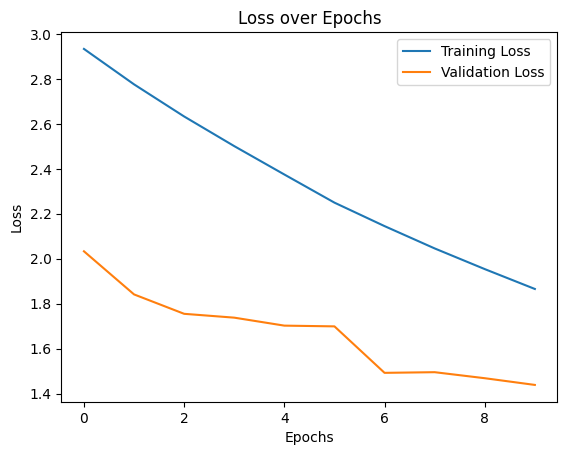

In [7]:
#Testing model:
# getting predictions of model:
y_test_pred = lstm_model.predict(X_test)
y_train_pred = lstm_model.predict(X_train)

train_loss, train_mae = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = lstm_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



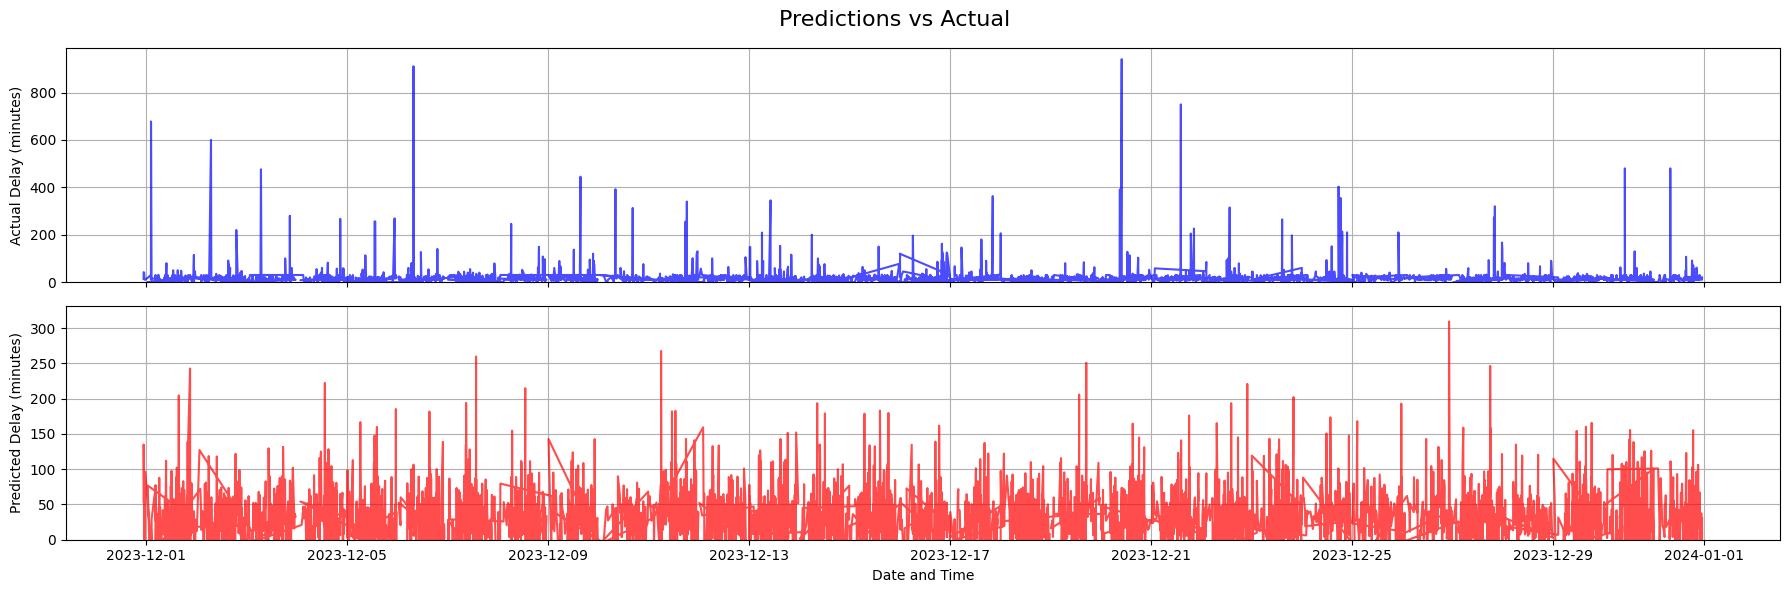

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_vs_real(y_test, y_test_pred, X_test, scaler, output_index=0, title="Predictions vs Actual"):
    """
    Plots the predicted vs actual values on separate plots, limited to the last month.
    
    Parameters:
    - y_test: Ground truth values (2D array with shape [samples, n_outputs]).
    - y_test_pred: Predicted values (2D array with shape [samples, n_outputs]).
    - X_test: Input features (3D array with time steps and features).
    - scaler: Scaler used to scale the data (e.g., StandardScaler).
    - output_index: Index of the output time step you want to plot (0-based).
    - title: Title for the plot.
    """
    # Extract only the output_index-th output for both y_test and y_test_pred
    y_test_single = y_test[:, output_index]
    y_test_pred_single = y_test_pred[:, output_index]

    # Ensure data is 1D
    y_test_single = y_test_single.flatten()
    y_test_pred_single = y_test_pred_single.flatten()

    # Unscale the data
    y_test_unscaled = scaler.inverse_transform(y_test_single.reshape(-1, 1)).flatten()
    y_test_pred_unscaled = scaler.inverse_transform(y_test_pred_single.reshape(-1, 1)).flatten()

    # Extract datetime features from X_test
    datetime_features = X_test[:, :, -5:]  # Last 5 columns for datetime features (year, month, etc.)
    last_timestep_datetime = datetime_features[:, -1, :]  # Take datetime info from the last time step

    # Create a DataFrame for datetime information
    datetime_df = pd.DataFrame(last_timestep_datetime, columns=['year', 'month', 'day', 'hour', 'minute'])
    datetime_df['datetime'] = pd.to_datetime(datetime_df[['year', 'month', 'day', 'hour', 'minute']])

    # Filter the datetime range to the last month
    datetime_df['datetime'] = pd.to_datetime(datetime_df['datetime'])
    last_month = datetime_df['datetime'].max() - pd.DateOffset(months=1)
    datetime_df = datetime_df[datetime_df['datetime'] >= last_month]

    # Filter the data for the last month
    y_test_unscaled_month = y_test_unscaled[datetime_df.index]
    y_test_pred_unscaled_month = y_test_pred_unscaled[datetime_df.index]

    # Plotting the results with separate plots for actual and predicted values
    fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

    # Plot actual values
    axs[0].plot(datetime_df['datetime'], y_test_unscaled_month, label="Actual", color="blue", alpha=0.7)
    axs[0].set_ylabel("Actual Delay (minutes)")
    axs[0].set_ylim(bottom=0)
    axs[0].grid(True)

    # Plot predicted values
    axs[1].plot(datetime_df['datetime'], y_test_pred_unscaled_month, label="Predicted", color="red", alpha=0.7)
    axs[1].set_xlabel("Date and Time")
    axs[1].set_ylabel("Predicted Delay (minutes)")
    axs[1].set_ylim(bottom=0)
    axs[1].grid(True)

    # Set the main title for the entire figure
    fig.suptitle(title, fontsize=16)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Call the plotting function
plot_predictions_vs_real(y_test, y_test_pred, X_test, scaler, output_index=0)


In [9]:
input_shape = (X_train.shape[0], X_train.shape[2])  # num samples, num features in each sample

# GRU model
gru_model = models.Sequential()
gru_model.add(layers.GRU(num_neurons,
                         activation='relu',
                         return_sequences=True,  # so we can use multiple GRU layers
                         input_shape=input_shape))
gru_model.add(layers.Dropout(0.3))
gru_model.add(layers.GRU(num_neurons//2,
                         activation='relu'))
gru_model.add(layers.Dropout(0.3))
gru_model.add(layers.Dense(1))  # for the final output layer since it's only 1 output

optimizer = Adam(learning_rate=adam_lr)  # setting optimizer

gru_model.compile(optimizer=optimizer, metrics=['mae'], loss='mae')  # use mae for regression

# creating model
gru_model.summary()

# fitting model
start_time = time.time()
gru_history = gru_model.fit(X_train, y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,  # 0.2 of the training set to be used for validation
                        verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time - start_time), 2)))

/home/jadenh/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 513384, 128)    │        54,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 513384, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,457 (357.25 KB)

 Trainable params: 91,457 (357.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - loss: 54.8009 - mae: 54.8009 - val_loss: 22.8226 - val_mae: 22.8226
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 46.6197 - mae: 46.6197 - val_loss: 1.7655 - val_mae: 1.7655
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 37.6026 - mae: 37.6026 - val_loss: 18.2455 - val_mae: 18.2455
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 31.8796 - mae: 31.8796 - val_loss: 8.8329 - val_mae: 8.8329
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 26.2842 - mae: 26.2842 - val_loss: 0.8399 - val_mae: 0.8399
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 20.8147 - mae: 20.8147 - val_loss: 2.0014 - val_mae: 2.0014
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 15.7539 - mae: 15.7539 - val_loss: 2.3692 - val_mae: 2.3692
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 11.4788 - mae: 11.4788 - val_loss: 0.6938 - val_mae: 0.6938
Epoch 9/10
803/803 ━

4011/4011 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step
16044/16044 ━━━━━━━━━━━━━━━━━━━━ 124s 8ms/step
TensorFlow Evaluation:
Training Loss (MSE): 0.2528, Training MAE: 0.2528
Testing Loss (MSE): 0.2240, Testing MAE: 0.2240


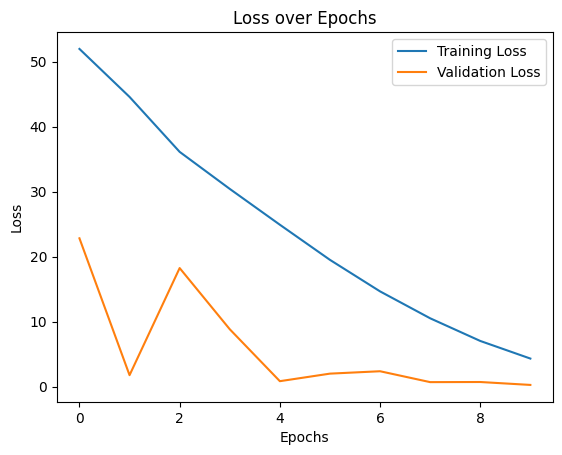

In [10]:
#Testing model:
# getting predictions of model:
y_test_pred = gru_model.predict(X_test)
y_train_pred = gru_model.predict(X_train)

train_loss, train_mae = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = gru_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
# RNN model
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(num_neurons,
                               activation='relu',
                               return_sequences=True,  # so we can use multiple RNN layers
                               input_shape=input_shape))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.SimpleRNN(num_neurons//2,
                               activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))  # for the final output layer since it's only 1 output

optimizer = Adam(learning_rate=adam_lr)  # setting optimizer

rnn_model.compile(optimizer=optimizer, metrics=['mae'], loss='mae')  # use mae for regression

# creating model
rnn_model.summary()

# fitting model
start_time = time.time()
rnn_history = rnn_model.fit(X_train, y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,  # 0.2 of the training set to be used for validation
                        verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time - start_time), 2)))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 513384, 128)    │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 513384, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,337 (118.50 KB)

 Trainable params: 30,337 (118.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 243.4381 - mae: 243.4381 - val_loss: 6.9644 - val_mae: 6.9644
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 87.7835 - mae: 87.7835 - val_loss: 20.7168 - val_mae: 20.7168
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 41.8860 - mae: 41.8860 - val_loss: 6.7130 - val_mae: 6.7130
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 16.9950 - mae: 16.9950 - val_loss: 0.4529 - val_mae: 0.4529
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 6.5376 - mae: 6.5376 - val_loss: 0.2265 - val_mae: 0.2265
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.8006 - mae: 2.8006 - val_loss: 0.2278 - val_mae: 0.2278
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 1.3729 - mae: 1.3729 - val_loss: 0.2273 - val_mae: 0.2273
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.7913 - mae: 0.7913 - val_loss: 0.2270 - val_mae: 0.2270
Epoch 9/10
803/803 ━━━━━━━━━

4011/4011 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step
16044/16044 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step
TensorFlow Evaluation:
Training Loss (MSE): 0.2032, Training MAE: 0.2032
Testing Loss (MSE): 0.1932, Testing MAE: 0.1932


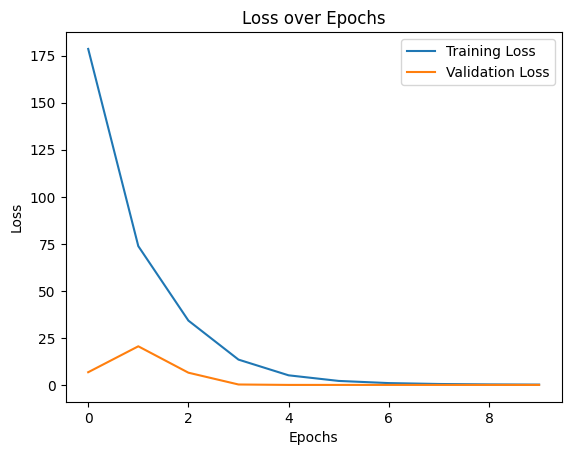

In [12]:
#Testing model:
# getting predictions of model:
y_test_pred = rnn_model.predict(X_test)
y_train_pred = rnn_model.predict(X_train)

train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



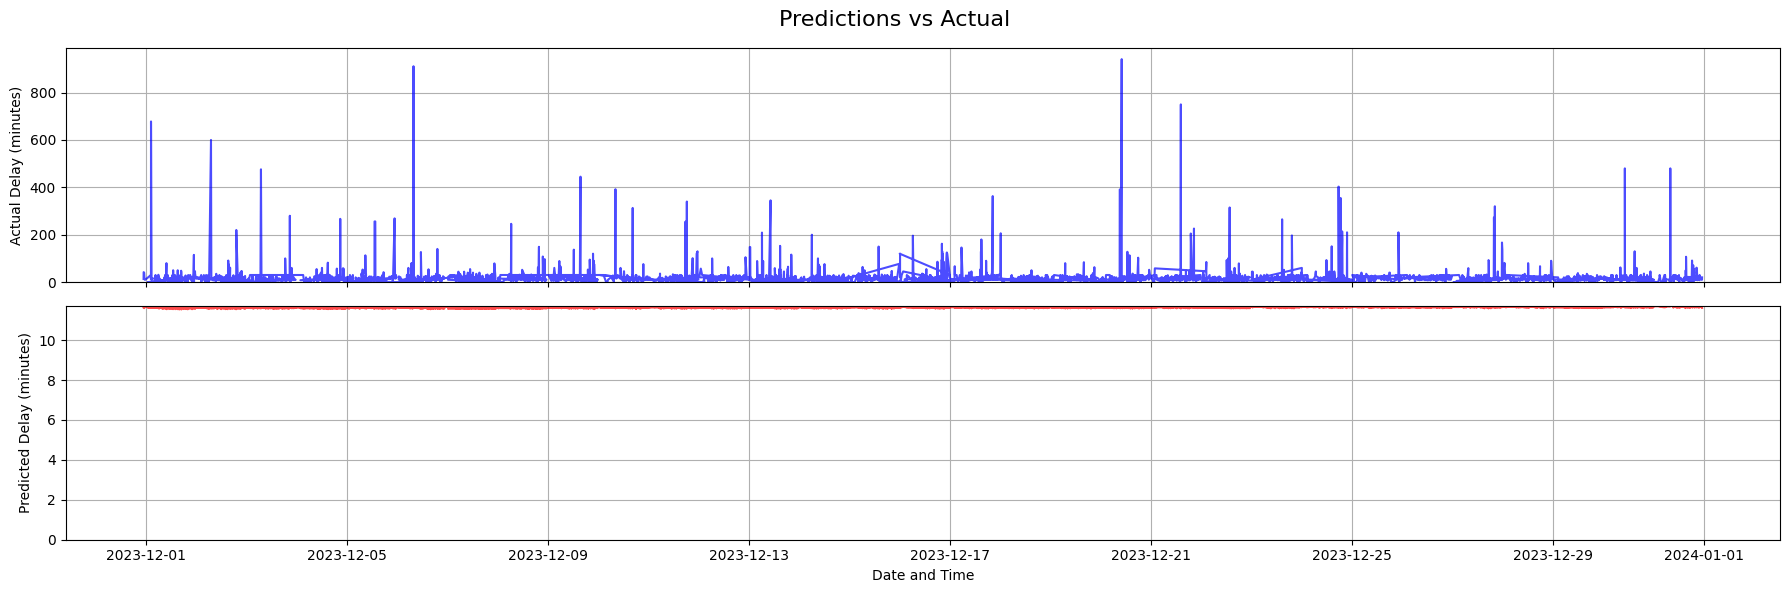

In [15]:
plot_predictions_vs_real(y_test, y_test_pred, X_test, scaler, output_index=0)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_forecast_only(forecasted_values_unscaled, X_test, title="Forecast for Next 30 Days"):
#     """
#     Plots the forecasted values for the next 30 days.

#     Parameters:
#     - forecasted_values_unscaled: Predicted values for the next 30 days (1D array of length 30).
#     - X_test: The input data (to extract datetime information).
#     - title: Title for the plot.
#     """
#     # Extract datetime information from the last window of X_test
#     datetime_features = X_test[-1, :, -5:]  # Last window (most recent window) from X_test
#     last_timestep_datetime = datetime_features[-1, :]  # Get the last timestep's datetime
#     datetime_df = pd.DataFrame([last_timestep_datetime], columns=['year', 'month', 'day', 'hour', 'minute'])
    
#     # Convert to scalar datetime
#     last_datetime = pd.to_datetime(datetime_df.iloc[0])
    
#     # Generate the datetime range
#     datetime_range = last_datetime + pd.to_timedelta(np.arange(30), unit='D')

#     # Check if forecasted values and datetime range match
#     if len(forecasted_values_unscaled) != len(datetime_range):
#         raise ValueError(
#             f"Mismatch in dimensions: forecasted_values_unscaled={len(forecasted_values_unscaled)}, "
#             f"datetime_range={len(datetime_range)}"
#         )

#     # Plot the forecasted values for the next 30 days
#     plt.figure(figsize=(12, 6))
#     plt.plot(datetime_range, forecasted_values_unscaled, label="Forecasted", color="red", alpha=0.7)
#     plt.title(title)
#     plt.xlabel("Time")
#     plt.ylabel("Values")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # Step 1: Get the last window of data
# last_window = X_test[-1]  # The last sliding window (most recent data)

# # Step 2: Reshape the input data for prediction (LSTM expects 3D input: [samples, timesteps, features])
# last_window = last_window.reshape((1, last_window.shape[0], last_window.shape[1]))  # Shape: (1, n_steps, n_features)

# # Step 3: Predict the next 30 days
# forecasted_values = lstm_model.predict(last_window, batch_size=1)

# # Step 4: Reshape the forecasted values (correctly)
# forecasted_values = forecasted_values.flatten()  # Ensure it's a flat array with 30 elements

# # Step 5: If you used a scaler for your target variable, unscale the predictions
# forecasted_values_unscaled = lstm_scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten()

# # Call the plotting function with forecasted values
# plot_forecast_only(forecasted_values_unscaled, X_test)

